<hr style="border:3px solid #aa1227; border-radius: 8px; margin: 20px 0">

# 🔥 Detecção de Queimadas em Imagens de Satélite  
### Pipeline com Índices Espectrais + Random Forest

Este notebook implementa um **pipeline completo** para análise de imagens de satélite, visando a **detecção de áreas de queimadas** com uso de técnicas de **aprendizado de máquina**.  

O processo inclui:  
- Cálculo de índices espectrais (NDVI, NBR, dNBR)  
- Treinamento de modelo **Random Forest**  
- Avaliação de métricas (ROC/AUC)  
- Seleção do melhor modelo  

---

### Autor  
**Sávio Jenner Vianna Silva Rennó**  
Estudante de **Sistemas de Informação** – UNITAU  
Contato: [savioviannasilva131@gmail.com](mailto:savioviannasilva131@gmail.com)  

<hr style="border:1.5px dashed #aa1227; margin: 20px 0">


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Instalação das Dependências

Execute o comando abaixo para instalar todas as bibliotecas necessárias para o notebook:

```bash
pip install numpy rasterio matplotlib scikit-learn pandas tqdm joblib


In [88]:
pip install numpy rasterio matplotlib scikit-learn pandas tqdm joblib

Note: you may need to restart the kernel to use updated packages.


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Importação de Bibliotecas

Neste projeto, utilizamos bibliotecas essenciais para diferentes etapas do pipeline:

- **Manipulação de arquivos e dados** → `os`, `csv`, `numpy`, `pandas`  
- **Processamento de imagens raster** → `rasterio`  
- **Visualização de resultados** → `matplotlib`  
- **Machine Learning** → `sklearn`  
- **Progresso de execução** → `tqdm`  
- **Gestão de avisos** → `warnings`  


In [89]:
import os
import csv
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Funções para Índices Espectrais

Definimos funções responsáveis pelo cálculo de índices espectrais, que são **cruciais para análise de queimadas** em imagens de satélite:

- **NDVI (Normalized Difference Vegetation Index)**  
   Mede a **vitalidade da vegetação**, diferenciando áreas verdes de áreas degradadas.  

- **NBR (Normalized Burn Ratio)**  
   Destaca regiões **afetadas por fogo**, facilitando a detecção de queimadas.  


In [90]:
def compute_ndvi(red, nir, eps=1e-6):
    return (nir - red) / (nir + red + eps)

def compute_nbr(nir, swir2, eps=1e-6):
    return (nir - swir2) / (nir + swir2 + eps)

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

# Função de Cálculo de Métricas de Fogo

A função **`calculate_fire_metrics`** é responsável por avaliar a performance da detecção de queimadas.  
Ela calcula:  

- **Área de fogo de referência** (ground truth)  
- **Área de fogo predita** (modelo)  
- **Overlap entre áreas queimadas**  
- **Métricas de avaliação**:  
  - **Recall** → capacidade de encontrar queimadas reais  
  - **Precision** → confiabilidade das áreas detectadas  
  - **F1-Score** → equilíbrio entre Recall e Precision  


In [91]:
def calculate_fire_metrics(mask_ref, mask_pred):
    fire_area_ref = np.sum(mask_ref == 1)
    total_pixels = mask_ref.size
    
    fire_area_pred = np.sum(mask_pred == 1)
    fire_percentage_ref = (fire_area_ref / total_pixels) * 100
    fire_percentage_pred = (fire_area_pred / total_pixels) * 100
    fire_overlap = np.sum((mask_ref == 1) & (mask_pred == 1))
    
    recall = fire_overlap / fire_area_ref if fire_area_ref > 0 else 0
    precision = fire_overlap / fire_area_pred if fire_area_pred > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'fire_area_ref': fire_area_ref,
        'fire_area_pred': fire_area_pred,
        'fire_percentage_ref': fire_percentage_ref,
        'fire_percentage_pred': fire_percentage_pred,
        'fire_overlap': fire_overlap,
        'recall': recall,
        'precision': precision,
        'f1_score': f1
    }

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

# Função de Análise de Queimadas em Imagens

A função **`process_image_with_fire_analysis`** implementa o pipeline completo de análise de imagens multitemporais para detecção de queimadas.  

Etapas principais:  

- **Carregamento de imagens multitemporais** (T1 e T2)  
- **Cálculo de índices espectrais**: NDVI, NBR e dNBR  
- **Preparação de features** para entrada no modelo  
- **Treinamento do modelo Random Forest**  
- **Predições e cálculo de métricas** de desempenho  
- **Retorno dos resultados consolidados** para análise  


In [92]:
def process_image_with_fire_analysis(file_name, t1_dir, t2_dir, mask_dir):
    try:
        # Carregamento das imagens
        with rasterio.open(os.path.join(t1_dir, file_name)) as src1:
            img1 = src1.read().astype("float32")
            profile = src1.profile

        with rasterio.open(os.path.join(t2_dir, file_name)) as src2:
            img2 = src2.read().astype("float32")

        # Extração de bandas
        red1, nir1 = img1[0], img1[3]
        red2, nir2 = img2[0], img2[3]
        swir21, swir22 = red1, red2

        # Cálculo de índices
        NDVI1 = compute_ndvi(red1, nir1)
        NDVI2 = compute_ndvi(red2, nir2)
        NBR1 = compute_nbr(nir1, swir21)
        NBR2 = compute_nbr(nir2, swir22)
        dNBR = NBR1 - NBR2

        # Preparação das features
        features = np.stack([
            NDVI1.ravel(),
            NDVI2.ravel(),
            NBR1.ravel(),
            NBR2.ravel(),
            dNBR.ravel(),
            (nir2 - nir1).ravel(),
            (swir22 - swir21).ravel()
        ], axis=1)

        # Carregamento da máscara
        with rasterio.open(os.path.join(mask_dir, file_name)) as ref_src:
            y = ref_src.read(1).ravel()
            mask_ref = ref_src.read(1)

        # Filtragem de pixels válidos
        mask_valid = (~np.isnan(features).any(axis=1)) & (~np.isnan(y))
        X = features[mask_valid]
        y = y[mask_valid]

        if len(np.unique(y)) < 2:
            return None

        # Split dos dados
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Treinamento do modelo
        clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)

        if clf.n_classes_ == 1:
            return None
        
        # Predição e avaliação
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        # Predição completa
        y_full_pred = np.zeros(features.shape[0], dtype="uint8")
        y_full_pred[mask_valid] = clf.predict(features[mask_valid])
        mask_pred = y_full_pred.reshape(mask_ref.shape)

        # Cálculo de métricas
        fire_metrics = calculate_fire_metrics(mask_ref, mask_pred)

        return {
            'file': file_name,
            'auc': auc,
            'clf': clf,
            'profile': profile,
            'mask_ref': mask_ref,
            'mask_pred': mask_pred,
            'fire_metrics': fire_metrics,
            'fpr': fpr,
            'tpr': tpr
        }

    except Exception as e:
        print(f"❌ Erro ao processar {file_name}: {str(e)}")
        return None

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

# Definição de Diretórios de Entrada

Nesta etapa, são definidos os diretórios que contêm os dados necessários para o pipeline:  

- **Imagens temporais T1 e T2** → utilizadas para comparação multitemporal  
- **Máscaras de referência** → indicam áreas de queimadas reais (ground truth)  

Além disso, o script **identifica os arquivos comuns** entre os diretórios, garantindo que apenas pares correspondentes sejam processados.  


In [93]:
t1_dir = "kaggle/input/worcap-2025/dataset_kaggle/dataset/t1/"
t2_dir = "kaggle/input/worcap-2025/dataset_kaggle/dataset/t2/"
mask_dir = "kaggle/input/worcap-2025/dataset_kaggle/dataset/mask/"

t1_files = [f for f in os.listdir(t1_dir) if f.endswith('.tif')]
t2_files = [f for f in os.listdir(t2_dir) if f.endswith('.tif')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.tif')]

common_files = list(set(t1_files) & set(t2_files) & set(mask_files))
common_files.sort()

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Processamento das Imagens

Nesta etapa, cada imagem é processada utilizando:  

- **Barra de progresso** (`tqdm`) para acompanhamento da execução  
- **Função principal de processamento** (`process_image_with_fire_analysis`)  
- **Armazenamento dos resultados válidos** em uma lista `results`  

Essa abordagem garante **monitoramento em tempo real** e consolidação organizada dos dados processados.  


In [94]:
results = []
for file_name in tqdm(common_files, desc="Analisando imagens"):
    result = process_image_with_fire_analysis(file_name, t1_dir, t2_dir, mask_dir)
    if result is not None:
        results.append(result)

Analisando imagens: 100%|██████████| 945/945 [02:33<00:00,  6.15it/s]


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Conversão dos Resultados em DataFrame

Após o processamento das imagens, os resultados são organizados em um **DataFrame do pandas** contendo:  

- **Nome do arquivo** → identifica cada imagem processada  
- **Métrica AUC** → desempenho do modelo Random Forest  
- **Métricas de incêndio calculadas** → Recall, Precision, F1-Score, Overlap  

Essa estrutura facilita a **visualização, análise e exportação** dos dados obtidos.  


In [95]:
df_data = []
for result in results:
    row = {
        'file': result['file'],
        'auc': result['auc'],
        **result['fire_metrics']
    }
    df_data.append(row)

df_results = pd.DataFrame(df_data)

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

# Organização e Ordenação dos Resultados

Os resultados consolidados podem ser **ordenados por diferentes critérios** para facilitar a análise:  

- **Maior AUC** → identifica os modelos com melhor desempenho global  
- **Maior área de fogo detectada** → prioriza imagens com detecção mais ampla  
- **Maior F1-Score** → equilíbrio entre Recall e Precision  
- **Score combinado** → métrica composta: `AUC * F1 * % área de fogo`  


In [96]:
df_by_auc = df_results.sort_values('auc', ascending=False)
df_by_fire_area = df_results.sort_values('fire_percentage_ref', ascending=False)
df_by_f1 = df_results.sort_values('f1_score', ascending=False)
df_results['combined_score'] = (df_results['auc'] * 
                               df_results['f1_score'] * 
                               (df_results['fire_percentage_ref'] / 100))
df_by_combined = df_results.sort_values('combined_score', ascending=False)

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Estatísticas Gerais do Processamento

Nesta etapa, são apresentadas **estatísticas resumidas** do processamento das imagens:  

- **Total de imagens processadas**  
- **Métricas médias**:  
  - **AUC** → desempenho médio do modelo  
  - **Área de fogo** → cobertura média detectada  
  - **F1-Score** → equilíbrio médio entre Recall e Precision  
  - **Recall** → capacidade média de detectar queimadas reais  
  - **Precision** → confiabilidade média das áreas detectadas  


In [97]:
print(f"📊 Total de imagens analisadas: {len(results)}")
print(f"\n📊 ESTATÍSTICAS GERAIS:")
print(f"   AUC médio: {df_results['auc'].mean():.4f}")
print(f"   Área de fogo média (referência): {df_results['fire_percentage_ref'].mean():.2f}%")
print(f"   F1 Score médio: {df_results['f1_score'].mean():.4f}")
print(f"   Recall médio: {df_results['recall'].mean():.4f}")
print(f"   Precision média: {df_results['precision'].mean():.4f}")

📊 Total de imagens analisadas: 603

📊 ESTATÍSTICAS GERAIS:
   AUC médio: 0.8475
   Área de fogo média (referência): 2.16%
   F1 Score médio: 0.8700
   Recall médio: 0.7991
   Precision média: 0.9668


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Visualização dos Top Resultados

Nesta etapa, exibimos os **melhores resultados** considerando quatro categorias:  

- **Top 10 por AUC** → modelos com melhor desempenho geral  
- **Top 10 por área de fogo** → imagens com maior cobertura de queimadas detectada  
- **Top 10 por F1-Score** → equilíbrio entre Recall e Precision  
- **Top 10 por score combinado** → métrica composta (`AUC * F1 * % área de fogo`)  

Essa visualização facilita **comparar e identificar rapidamente** os modelos mais eficazes.  


In [98]:
print("🥇 TOP 10 POR AUC:")
print(df_by_auc[['file', 'auc', 'fire_percentage_ref', 'f1_score']].head(10))

print("\n🔥 TOP 10 POR ÁREA DE FOGO:")
print(df_by_fire_area[['file', 'fire_percentage_ref', 'auc', 'f1_score']].head(10))

print("\n🎯 TOP 10 POR F1 SCORE:")
print(df_by_f1[['file', 'f1_score', 'auc', 'fire_percentage_ref']].head(10))

print("\n🏆 TOP 10 POR SCORE COMBINADO:")
print(df_by_combined[['file', 'combined_score', 'auc', 'f1_score', 'fire_percentage_ref']].head(10))

🥇 TOP 10 POR AUC:
                file       auc  fire_percentage_ref  f1_score
252  recorte_452.tif  1.000000             0.036621  0.800000
483  recorte_762.tif  1.000000             0.054932  0.941176
349  recorte_578.tif  1.000000             0.170898  0.901961
451  recorte_723.tif  1.000000             0.048828  1.000000
450  recorte_722.tif  1.000000             0.054932  1.000000
581  recorte_913.tif  1.000000             0.030518  1.000000
427  recorte_692.tif  0.999917             0.213623  0.970588
475  recorte_755.tif  0.999796             0.103760  0.838710
419  recorte_680.tif  0.999707             0.592041  0.957895
240  recorte_435.tif  0.999678             0.207520  0.970588

🔥 TOP 10 POR ÁREA DE FOGO:
                file  fire_percentage_ref       auc  f1_score
393  recorte_650.tif            40.856934  0.960412  0.965839
474  recorte_754.tif            34.832764  0.981941  0.979892
472  recorte_752.tif            27.893066  0.987525  0.979133
471  recorte_751.tif    

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Seleção do Melhor Resultado

Nesta etapa, selecionamos o **resultado mais representativo** com base no **score combinado**:  

- **Score combinado** → combina **AUC**, **F1-Score** e **% de área de fogo**  
- **Identificação do melhor resultado** → aquele com o maior score combinado, refletindo **desempenho global e cobertura de queimadas**


In [99]:
best_result = None
best_combined_score = 0

for result in results:
    combined_score = (result['auc'] * 
                     result['fire_metrics']['f1_score'] * 
                     (result['fire_metrics']['fire_percentage_ref'] / 100))
    
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_result = result

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Salvamento dos Artefatos do Melhor Modelo

Após identificar o melhor resultado, salvamos os **artefatos gerados** para uso futuro:  

- **Modelo treinado** → salvo no formato `joblib`  
- **Máscara predita** → exportada como `GeoTIFF`, preservando o **perfil espacial** das imagens originais  

Essa etapa garante **reprodutibilidade e integridade dos dados** para análises posteriores.


In [100]:
if best_result is not None:
    model_path = "melhor_modelo_area_fogo.joblib"
    joblib.dump(best_result['clf'], model_path)
    
    profile = best_result['profile']
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open("melhor_mascara_area_fogo.tif", "w", **profile) as dst:
        dst.write(best_result['mask_pred'], 1)

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Visualização do Melhor Resultado

Exibe lado a lado:  

- T1 - Pré-fogo (RGB)  
- T2 - Pós-fogo (RGB)  
- Máscara de Referência


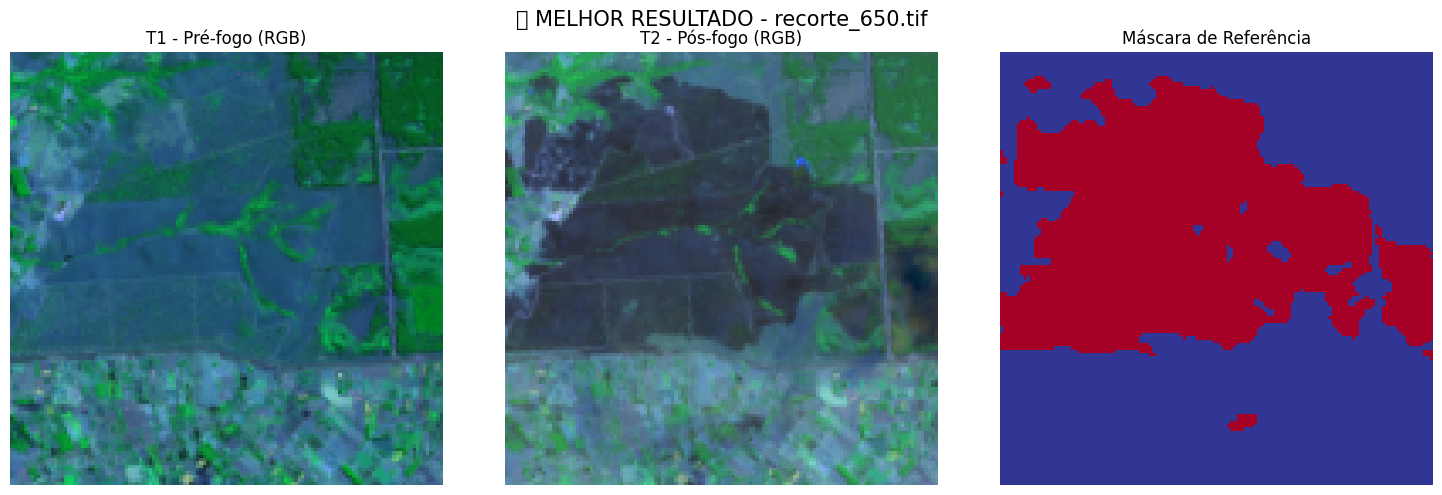

In [101]:
# Carregar imagens T1 e T2 do dataset de treinamento
train_t1_dir = "kaggle/input/worcap-2025/dataset_kaggle/dataset/t1/"
train_t2_dir = "kaggle/input/worcap-2025/dataset_kaggle/dataset/t2/"

t1_path = os.path.join(train_t1_dir, best_result['file'])
t2_path = os.path.join(train_t2_dir, best_result['file'])

with rasterio.open(t1_path) as src_t1:
    img_t1 = src_t1.read().astype("float32")
with rasterio.open(t2_path) as src_t2:
    img_t2 = src_t2.read().astype("float32")

# Composição RGB para T1 e T2
rgb_t1 = np.stack([img_t1[0], img_t1[1], img_t1[2]], axis=0)
rgb_t1 = np.transpose(rgb_t1, (1, 2, 0))
rgb_t1 = (rgb_t1 - rgb_t1.min()) / (rgb_t1.max() - rgb_t1.min())

rgb_t2 = np.stack([img_t2[0], img_t2[1], img_t2[2]], axis=0)
rgb_t2 = np.transpose(rgb_t2, (1, 2, 0))
rgb_t2 = (rgb_t2 - rgb_t2.min()) / (rgb_t2.max() - rgb_t2.min())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"🏆 MELHOR RESULTADO - {best_result['file']}", fontsize=15)

axes[0].imshow(rgb_t1)
axes[0].set_title("T1 - Pré-fogo (RGB)")
axes[0].axis('off')

axes[1].imshow(rgb_t2)
axes[1].set_title("T2 - Pós-fogo (RGB)")
axes[1].axis('off')

axes[2].imshow(best_result['mask_ref'], cmap='RdYlBu_r')
axes[2].set_title("Máscara de Referência")
axes[2].axis('off')

plt.tight_layout()
plt.show()


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Informações do Melhor Modelo

Nesta seção, apresentamos os **detalhes do melhor modelo selecionado**:  

- **Nome do arquivo** → identifica a imagem/processamento correspondente  
- **Métricas principais** → AUC, F1-Score, área de fogo detectada  
- **Curva ROC** → visualização do desempenho do modelo na detecção de queimadas  

Essa análise permite **avaliar de forma completa** a qualidade do modelo e sua capacidade de generalização.


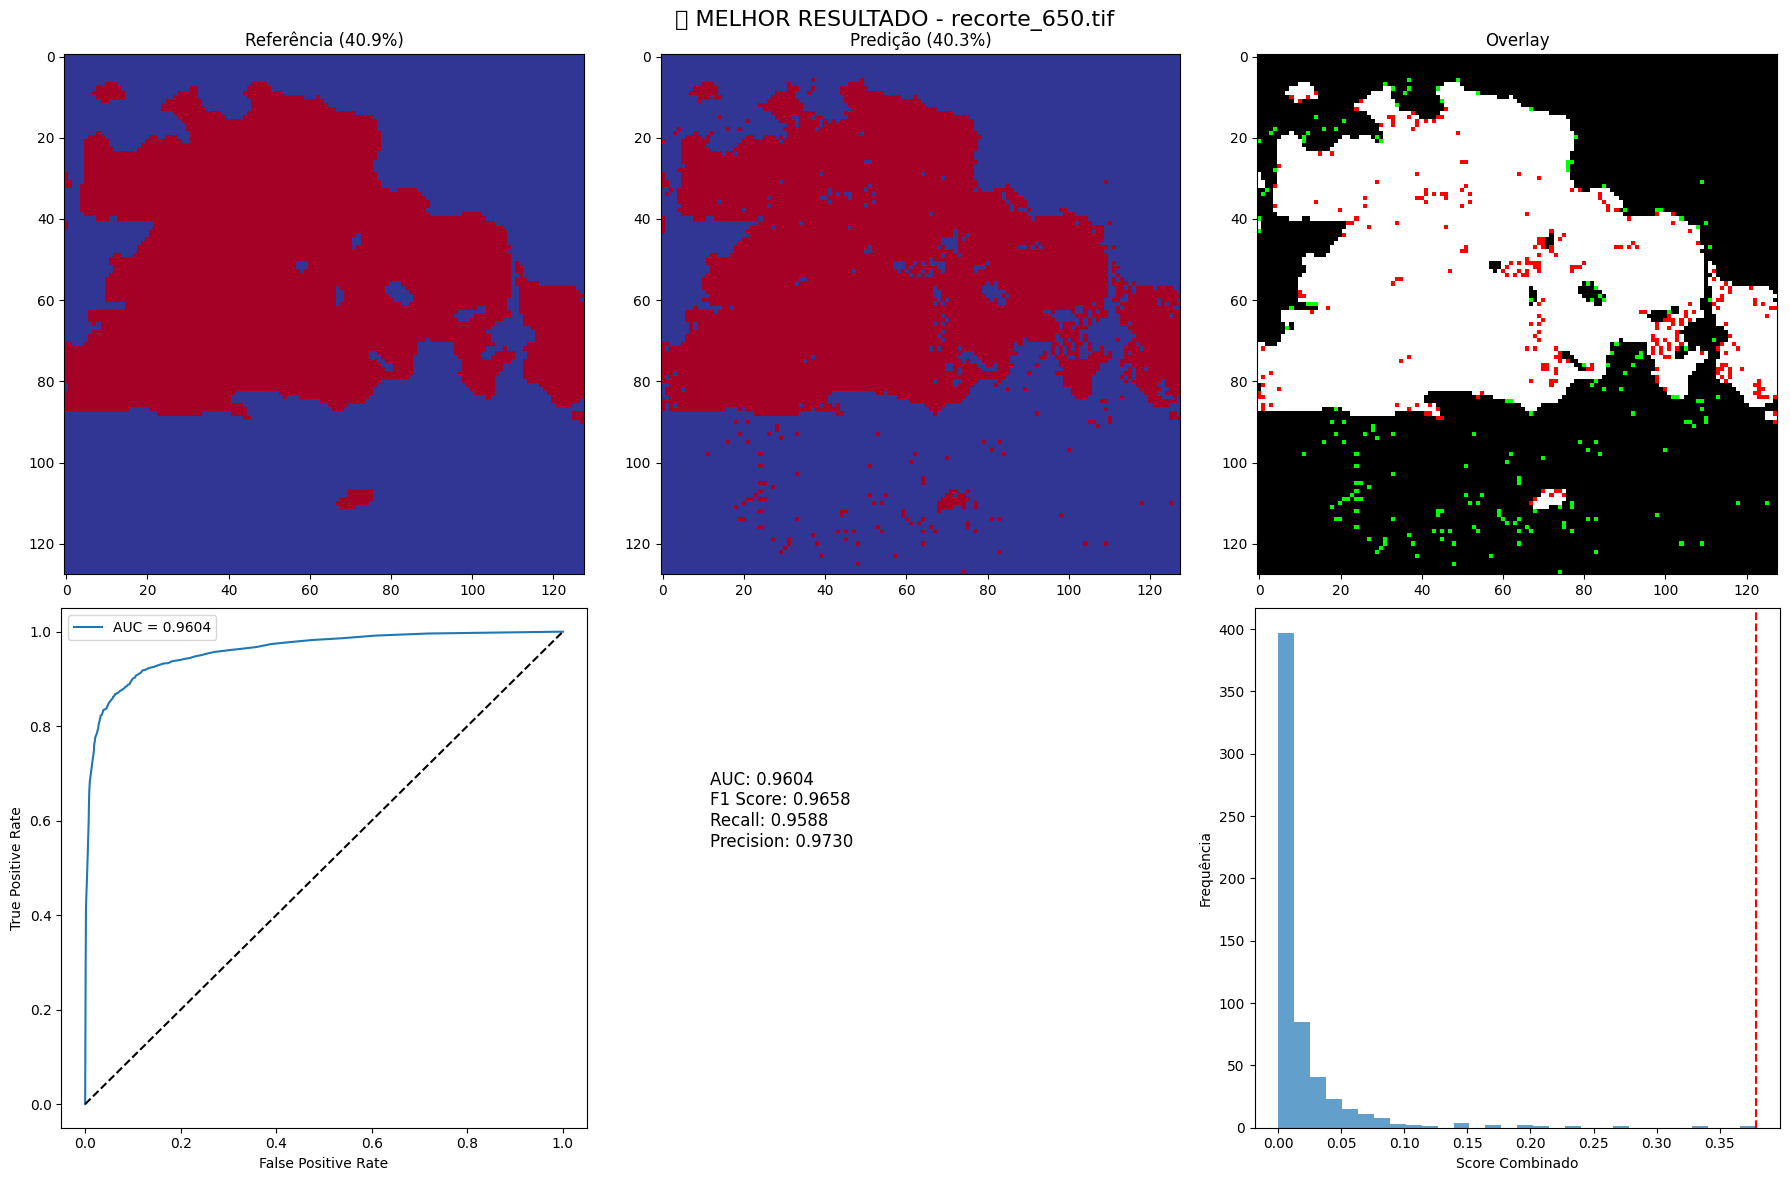

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'🏆 MELHOR RESULTADO - {best_result["file"]}', fontsize=16)

# Gráficos da máscara de referência, predição e overlay
axes[0, 0].imshow(best_result['mask_ref'], cmap='RdYlBu_r')
axes[0, 0].set_title(f'Referência ({best_result["fire_metrics"]["fire_percentage_ref"]:.1f}%)')

axes[0, 1].imshow(best_result['mask_pred'], cmap='RdYlBu_r')
axes[0, 1].set_title(f'Predição ({best_result["fire_metrics"]["fire_percentage_pred"]:.1f}%)')

overlay = np.zeros((*best_result['mask_ref'].shape, 3))
overlay[best_result['mask_ref'] == 1, 0] = 1
overlay[best_result['mask_pred'] == 1, 1] = 1
overlay[(best_result['mask_ref'] == 1) & (best_result['mask_pred'] == 1), 2] = 1
axes[0, 2].imshow(overlay)
axes[0, 2].set_title('Overlay')

# Curva ROC
axes[1, 0].plot(best_result['fpr'], best_result['tpr'], label=f"AUC = {best_result['auc']:.4f}")
axes[1, 0].plot([0, 1], [0, 1], "k--")
axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
axes[1, 0].legend()

# Métricas textuais
metrics_text = f"""
AUC: {best_result['auc']:.4f}
F1 Score: {best_result['fire_metrics']['f1_score']:.4f}
Recall: {best_result['fire_metrics']['recall']:.4f}
Precision: {best_result['fire_metrics']['precision']:.4f}
"""
axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12)
axes[1, 1].axis('off')

# Histograma de scores
axes[1, 2].hist(df_results['combined_score'], bins=30, alpha=0.7)
axes[1, 2].axvline(best_combined_score, color='red', linestyle='--')
axes[1, 2].set_xlabel('Score Combinado')
axes[1, 2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Gráfico de Correlação

Visualiza a relação entre:  

- **Área de Fogo na Referência (%)**  
- **AUC Score**  

O **F1 Score** é representado pela cor, e o **melhor resultado** é destacado em vermelho com estrela.


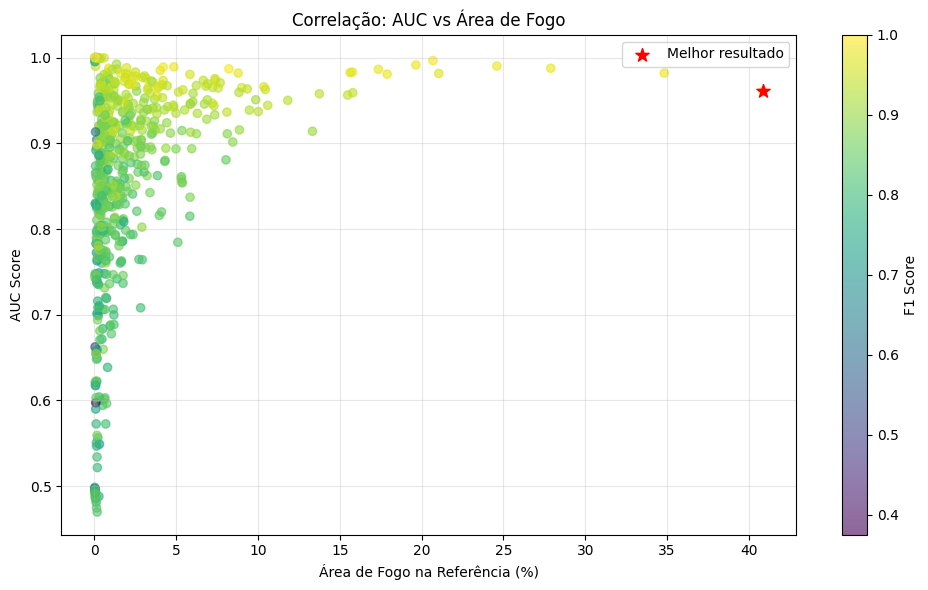

In [103]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_results['fire_percentage_ref'], df_results['auc'], 
                    c=df_results['f1_score'], cmap='viridis', alpha=0.6)
plt.colorbar(label='F1 Score')
plt.xlabel('Área de Fogo na Referência (%)')
plt.ylabel('AUC Score')
plt.title('Correlação: AUC vs Área de Fogo')
plt.grid(True, alpha=0.3)

# Destacar o melhor resultado
plt.scatter(best_result['fire_metrics']['fire_percentage_ref'], 
            best_result['auc'], c='red', s=100, marker='*', 
            label='Melhor resultado')
plt.legend()

plt.tight_layout()
plt.show()

<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Geração do CSV com Máscaras Preditivas

Nesta célula, processamos o **dataset de avaliação** utilizando o **melhor modelo treinado**:  

- Carrega pares de imagens **T1 (pré-fogo) e T2 (pós-fogo)**  
- Calcula **features espectrais**: NDVI, NBR, dNBR, e diferenças entre bandas  
- Realiza **predições de máscara de fogo** usando o modelo Random Forest  
- Salva as máscaras preditas em **formato CSV (flattened)**  
- Mostra progresso a cada 50 imagens processadas  

O CSV gerado pode ser utilizado para **avaliação quantitativa** ou visualização posterior.


In [104]:
import os
import csv
import rasterio
import numpy as np
import joblib

# Carregar o melhor modelo treinado
model_path = "melhor_modelo_area_fogo.joblib"
model = joblib.load(model_path)

# Caminhos das pastas
t1_dir = "kaggle/input/worcap-2025/dataset_kaggle/avaliacao/t1"
t2_dir = "kaggle/input/worcap-2025/dataset_kaggle/avaliacao/t2"

# Listar arquivos (assumindo nomes iguais em t1/ e t2/)
files_t1 = sorted(os.listdir(t1_dir))
files_t2 = sorted(os.listdir(t2_dir))

# Garante que a lista tem o mesmo tamanho
assert len(files_t1) == len(files_t2), "⚠️ T1 e T2 têm número diferente de arquivos!"

csv_path = "melhor_modelo_area_fogo.csv"

# Função para calcular features espectrais (mesma usada no treinamento)
def compute_ndvi(red, nir, eps=1e-6):
    return (nir - red) / (nir + red + eps)

def compute_nbr(nir, swir2, eps=1e-6):
    return (nir - swir2) / (nir + swir2 + eps)

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)

    # Definir header com base no tamanho da primeira predição
    with rasterio.open(os.path.join(t1_dir, files_t1[0])) as src1, \
         rasterio.open(os.path.join(t2_dir, files_t2[0])) as src2:

        # Ler imagens
        img1 = src1.read().astype("float32")
        img2 = src2.read().astype("float32")
        
        # Extrair bandas
        red1, nir1 = img1[0], img1[3]
        red2, nir2 = img2[0], img2[3]
        swir21, swir22 = red1, red2  # Usando red como proxy para SWIR2
        
        # Calcular features
        NDVI1 = compute_ndvi(red1, nir1)
        NDVI2 = compute_ndvi(red2, nir2)
        NBR1 = compute_nbr(nir1, swir21)
        NBR2 = compute_nbr(nir2, swir22)
        dNBR = NBR1 - NBR2
        
        # Preparar features
        features = np.stack([
            NDVI1.ravel(),
            NDVI2.ravel(),
            NBR1.ravel(),
            NBR2.ravel(),
            dNBR.ravel(),
            (nir2 - nir1).ravel(),
            (swir22 - swir21).ravel()
        ], axis=1)
        
        # Filtrar pixels válidos
        mask_valid = ~np.isnan(features).any(axis=1)
        num_pixels = mask_valid.sum()
        
        header = ["id"] + [f"pixel_{i}" for i in range(num_pixels)]
        writer.writerow(header)

    # Iterar sobre todos os pares T1/T2
    for idx, (f1, f2) in enumerate(zip(files_t1, files_t2)):
        id_sample = os.path.splitext(f1)[0]  # nome base do arquivo

        # Ler T1 e T2
        with rasterio.open(os.path.join(t1_dir, f1)) as src1, \
             rasterio.open(os.path.join(t2_dir, f2)) as src2:

            # Ler imagens
            img1 = src1.read().astype("float32")
            img2 = src2.read().astype("float32")
            
            # Extrair bandas
            red1, nir1 = img1[0], img1[3]
            red2, nir2 = img2[0], img2[3]
            swir21, swir22 = red1, red2  # Usando red como proxy para SWIR2
            
            # Calcular features
            NDVI1 = compute_ndvi(red1, nir1)
            NDVI2 = compute_ndvi(red2, nir2)
            NBR1 = compute_nbr(nir1, swir21)
            NBR2 = compute_nbr(nir2, swir22)
            dNBR = NBR1 - NBR2
            
            # Preparar features
            features = np.stack([
                NDVI1.ravel(),
                NDVI2.ravel(),
                NBR1.ravel(),
                NBR2.ravel(),
                dNBR.ravel(),
                (nir2 - nir1).ravel(),
                (swir22 - swir21).ravel()
            ], axis=1)
            
            # Filtrar pixels válidos
            mask_valid = ~np.isnan(features).any(axis=1)
            X = features[mask_valid]
            
            # Predição da máscara
            pred_proba = model.predict_proba(X)[:, 1]
            pred_mask = (pred_proba > 0.5).astype(int)
            
            # Criar máscara completa (preenchida com zeros para pixels inválidos)
            full_mask = np.zeros(features.shape[0], dtype=int)
            full_mask[mask_valid] = pred_mask

        # Escrever linha no CSV
        row = [id_sample] + full_mask.tolist()
        writer.writerow(row)
        
        if (idx + 1) % 50 == 0:
            print(f"Processado {idx + 1}/{len(files_t1)} imagens...")

print(f"✅ Máscaras preditas (flatten) salvas em '{csv_path}'")


Processado 50/315 imagens...
Processado 100/315 imagens...
Processado 150/315 imagens...
Processado 200/315 imagens...
Processado 250/315 imagens...
Processado 300/315 imagens...
✅ Máscaras preditas (flatten) salvas em 'melhor_modelo_area_fogo.csv'


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Visualização do CSV de Máscaras Preditivas

Carrega e exibe o **CSV gerado** contendo as máscaras preditas pelo melhor modelo.


In [105]:
import pandas as pd 

pd.read_csv('melhor_modelo_area_fogo.csv')

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_16374,pixel_16375,pixel_16376,pixel_16377,pixel_16378,pixel_16379,pixel_16380,pixel_16381,pixel_16382,pixel_16383
0,recorte_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,recorte_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,recorte_100,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,1,0,0
3,recorte_101,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,recorte_102,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,recorte_95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,recorte_96,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
312,recorte_97,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,recorte_98,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<hr style="border:2px inset #aa1227; border-radius:6px; margin:20px 0">

## Agradecimento

Obrigado por acompanhar este notebook!  
Espero que a análise e visualização das **áreas de queimadas** tenham sido claras e úteis.  

Para dúvidas ou sugestões, entre em contato: **savioviannasilva131@gmail.com**  
